## Names:
- Abhyudoy Chaki (21BCE0884)
- Shiva Khanduri (21BCE3508)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("rohanrao/nifty50-stock-market-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15


In [ ]:
import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/RELIANCE.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/NTPC.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/BRITANNIA.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/MARUTI.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/TATASTEEL.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/DRREDDY.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/ITC.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/JSWSTEEL.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/INFY.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/ULTRACEMCO.csv
/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/UPL.csv
/root

## Predicting TCS VWAP (Volume Weighted Average Price)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/TCS.csv')

In [ ]:
len(df)

4139

In [ ]:
df['Trades'].isnull().sum() / len(df)

0.4066199565112346

- 40.66% of the data in trades column is null, so we drop it

In [ ]:
df = df.drop(columns=['Trades'])

In [ ]:
df.isnull().sum()

,0
Date,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0


<Axes: xlabel='Date'>

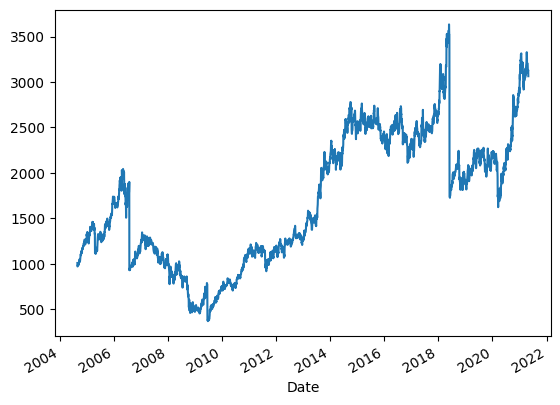

In [ ]:
import matplotlib.pyplot as plt
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df['VWAP'].plot()

- We select 'High', 'Low', 'Volume', 'Open' as our columns of interest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

np.random.seed(42)

columns_to_modify = ['High', 'Low', 'Volume', 'Open']

for column in columns_to_modify:
    nan_indices = np.random.choice(df.index, size=10, replace=False)
    df.loc[nan_indices, column] = np.nan

print("Summary of missing values after introducing NaNs:")
print(df.isnull().sum())

Summary of missing values after introducing NaNs:
Date                   0
Symbol                 0
Series                 0
Prev Close             0
Open                  10
High                  10
Low                   10
Last                   0
Close                  0
VWAP                   0
Volume                10
Turnover               0
Deliverable Volume     0
%Deliverble            0
dtype: int64


In [ ]:
numerical_columns = ['High', 'Low', 'Volume', 'Open']

for column in numerical_columns:
    df[column] = df[column].fillna(df[column].mean())

print("Summary of missing values after imputation:")
print(df.isnull().sum())

Summary of missing values after imputation:
Date                  0
Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Deliverable Volume    0
%Deliverble           0
dtype: int64


<Axes: xlabel='Date'>

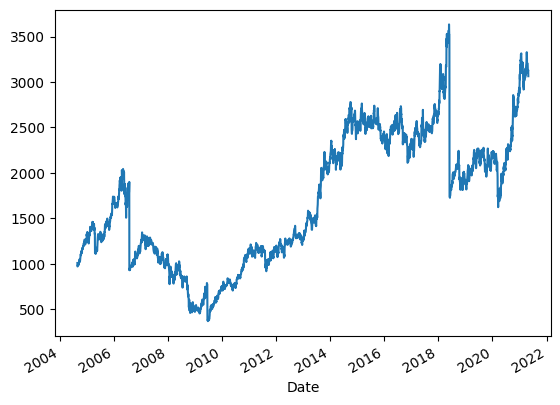

In [ ]:
df['VWAP'].plot()

In [ ]:
output_var = pd.DataFrame(df['VWAP'])

features = ['Open', 'High', 'Low', 'Volume']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

import joblib
joblib.dump(scaler, 'scaler_TCS.pkl')

['scaler_TCS.pkl']

In [ ]:
feature_transform.shape

(4139, 4)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=25)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(3980, 4)
(159, 4)


In [ ]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(3980, 1, 4)
(159, 1, 4)


In [ ]:
import tensorflow as tf

lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))


lstm.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 1, 32)               │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_85 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,633 (115.75 KB)

 Trainable params: 29,633 (115.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, validation_data=(X_test, y_test))

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1955607.8750 - mse: 1955607.8750 - val_loss: 8473919.0000 - val_mse: 8473919.0000
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1921888.8750 - mse: 1921888.8750 - val_loss: 7726900.5000 - val_mse: 7726900.5000
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1679991.5000 - mse: 1679991.5000 - val_loss: 5538915.5000 - val_mse: 5538915.5000
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1103497.5000 - mse: 1103497.5000 - val_loss: 2379929.0000 - val_mse: 2379929.0000
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 402072.6250 - mse: 402072.6250 - val_loss: 408660.6875 - val_mse: 408660.6875
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 51523.7422 - mse: 51523.7422 - val_loss: 22447.5723 - val_mse: 22447.5723
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7446.1528 - mse: 7446.1528 - val_loss: 4054.4001 - val_mse: 4054.4001
Epoch 8/100
125/125 ━━━

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mse,val_loss,val_mse
0,3.186067e+06,3.186067e+06,8.473919e+06,8.473919e+06
1,3.067434e+06,3.067434e+06,7.726900e+06,7.726900e+06
2,2.542182e+06,2.542182e+06,5.538916e+06,5.538916e+06
3,1.499751e+06,1.499751e+06,2.379929e+06,2.379929e+06
4,4.660105e+05,4.660105e+05,4.086607e+05,4.086607e+05
...,...,...,...,...
95,7.976071e+02,7.976071e+02,3.092090e+02,3.092090e+02
96,7.966176e+02,7.966176e+02,3.097213e+02,3.097213e+02
97,7.956254e+02,7.956254e+02,3.101399e+02,3.101399e+02
98,7.946349e+02,7.946349e+02,3.104680e+02,3.104680e+02


In [ ]:
lstm.save('/content/model_TCS.h5')

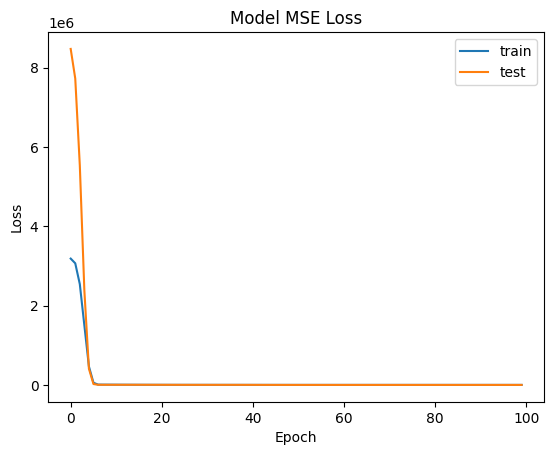

In [ ]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

In [ ]:
y_pred= lstm.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 310.72273601949587


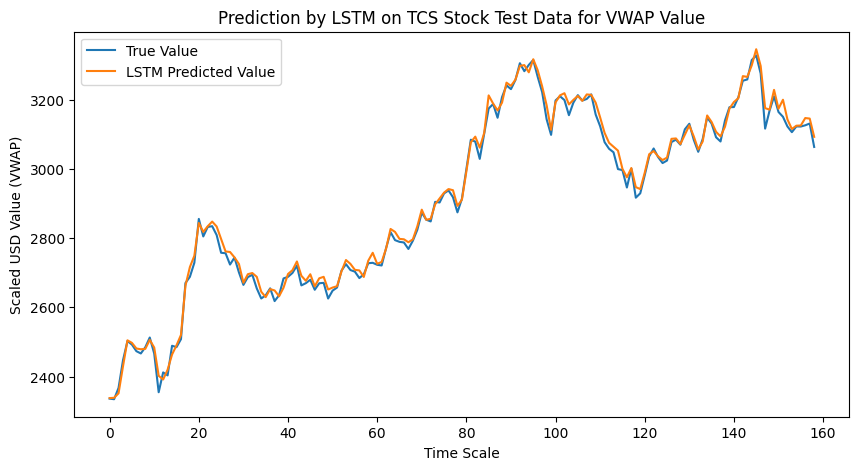

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Prediction by LSTM on TCS Stock Test Data for VWAP Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD Value (VWAP)')
plt.legend()
plt.show()

## Predicting HDFC VWAP (Volume Weighted Average Price)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/HDFC.csv')

In [ ]:
len(df)

5306

In [ ]:
print(df['Trades'].isnull().sum() / len(df))

0.5371277798718432


- 53.71% of the data in trades column is null, so we drop it

In [ ]:
df = df.drop(columns=['Trades'])

In [ ]:
df.isnull().sum()

,0
Date,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0


<Axes: xlabel='Date'>

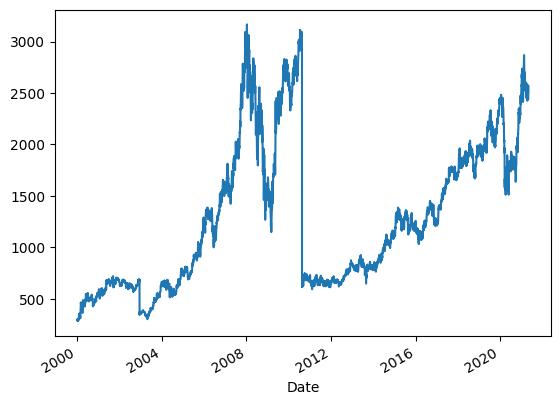

In [ ]:
import matplotlib.pyplot as plt
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df['VWAP'].plot()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

np.random.seed(42)

columns_to_modify = ['High', 'Low', 'Volume', 'Open']

for column in columns_to_modify:
    nan_indices = np.random.choice(df.index, size=10, replace=False)
    df.loc[nan_indices, column] = np.nan

print("Summary of missing values after introducing NaNs:")
print(df.isnull().sum())

Summary of missing values after introducing NaNs:
Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                   10
High                   10
Low                    10
Last                    0
Close                   0
VWAP                    0
Volume                 10
Turnover                0
Deliverable Volume    509
%Deliverble           509
dtype: int64


In [ ]:
numerical_columns = ['High', 'Low', 'Volume', 'Open']

for column in numerical_columns:
    df[column] = df[column].fillna(df[column].mean())

print("Summary of missing values after imputation:")
print(df.isnull().sum())

Summary of missing values after imputation:
Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Deliverable Volume    509
%Deliverble           509
dtype: int64


<Axes: xlabel='Date'>

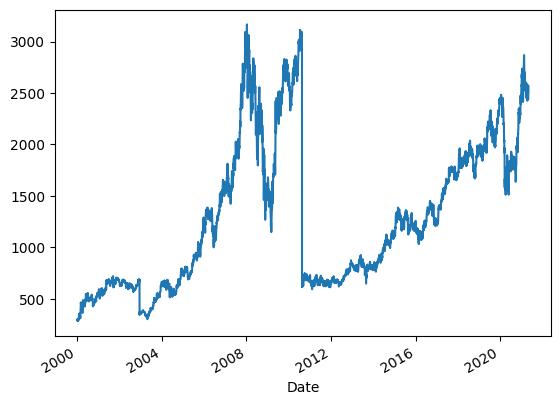

In [ ]:
df['VWAP'].plot()

In [ ]:
output_var = pd.DataFrame(df['VWAP'])

features = ['Open', 'High', 'Low', 'Volume']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

import joblib
joblib.dump(scaler, 'scaler_HDFC.pkl')

['scaler_HDFC.pkl']

In [ ]:
feature_transform.shape

(5306, 4)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=25)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5102, 4)
(204, 4)


In [ ]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(5102, 1, 4)
(204, 1, 4)


In [ ]:
import tensorflow as tf

lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))


lstm.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_86 (LSTM)                       │ (None, 1, 32)               │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_87 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,633 (115.75 KB)

 Trainable params: 29,633 (115.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, validation_data=(X_test, y_test))

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1258720.8750 - mse: 1258720.8750 - val_loss: 5077725.0000 - val_mse: 5077725.0000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1226586.5000 - mse: 1226586.5000 - val_loss: 4560121.0000 - val_mse: 4560121.0000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1012039.7500 - mse: 1012039.7500 - val_loss: 2972615.2500 - val_mse: 2972615.2500
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 540261.9375 - mse: 540261.9375 - val_loss: 990194.3750 - val_mse: 990194.3750
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 125333.5859 - mse: 125333.5859 - val_loss: 128277.9531 - val_mse: 128277.9531
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23090.6191 - mse: 23090.6191 - val_loss: 16175.4365 - val_mse: 16175.4365
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21937.7520 - mse: 21937.7520 - val_loss: 6993.7114 - val_mse: 6993.7114
Epoch 8/100
160/160 ━━━━━

In [ ]:
lstm.save('/content/model_HDFC.h5')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mse,val_loss,val_mse
0,2.029488e+06,2.029488e+06,5.077725e+06,5.077725e+06
1,1.938719e+06,1.938719e+06,4.560121e+06,4.560121e+06
2,1.510029e+06,1.510029e+06,2.972615e+06,2.972615e+06
3,7.287189e+05,7.287189e+05,9.901944e+05,9.901944e+05
4,1.558087e+05,1.558087e+05,1.282780e+05,1.282780e+05
...,...,...,...,...
95,4.565391e+02,4.565391e+02,1.576899e+03,1.576899e+03
96,4.557497e+02,4.557497e+02,1.583386e+03,1.583386e+03
97,4.549613e+02,4.549613e+02,1.589835e+03,1.589835e+03
98,4.541853e+02,4.541853e+02,1.596267e+03,1.596267e+03


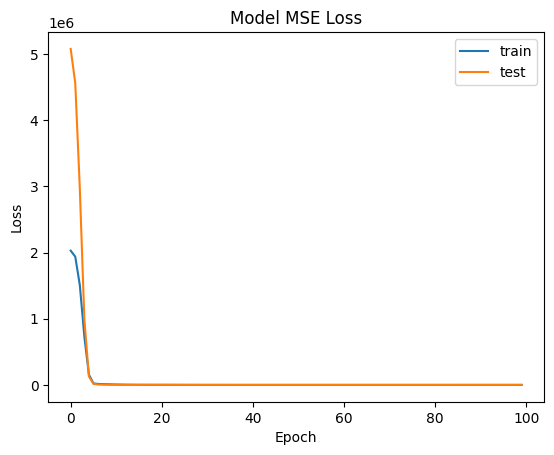

In [ ]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

In [ ]:
y_pred= lstm.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1602.703974247842


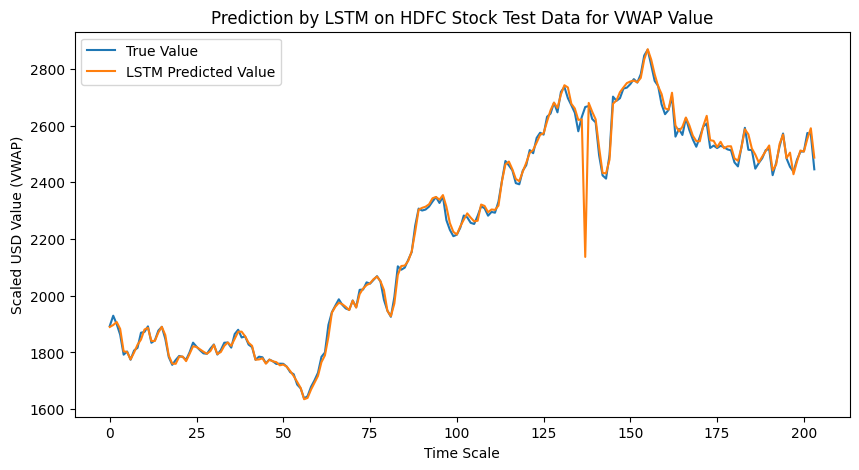

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Prediction by LSTM on HDFC Stock Test Data for VWAP Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD Value (VWAP)')
plt.legend()
plt.show()

## Predicting BHARTIARTL VWAP (Volume Weighted Average Price)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/BHARTIARTL.csv')

In [ ]:
len(df)

4774

In [ ]:
df['Trades'].isnull().sum() / len(df)

0.48554671135316296

- 48.55% of the data in trades column is null, so we drop it

In [ ]:
df = df.drop(columns=['Trades'])

In [ ]:
df.isnull().sum()

,0
Date,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0


<Axes: xlabel='Date'>

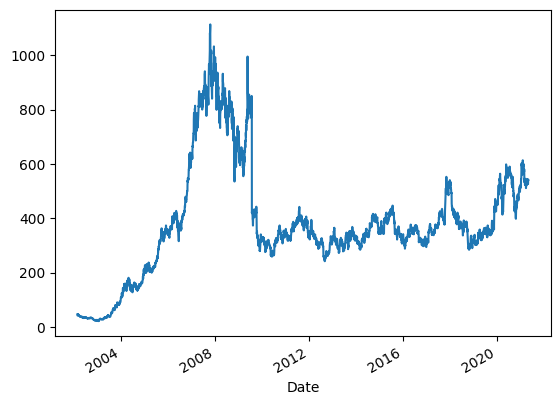

In [ ]:
import matplotlib.pyplot as plt
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df['VWAP'].plot()

- We select 'High', 'Low', 'Volume', 'Open' as our columns of interest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

np.random.seed(42)

columns_to_modify = ['High', 'Low', 'Volume', 'Open']

for column in columns_to_modify:
    nan_indices = np.random.choice(df.index, size=10, replace=False)
    df.loc[nan_indices, column] = np.nan

print("Summary of missing values after introducing NaNs:")
print(df.isnull().sum())

Summary of missing values after introducing NaNs:
Date                   0
Symbol                 0
Series                 0
Prev Close             0
Open                  10
High                  10
Low                   10
Last                   0
Close                  0
VWAP                   0
Volume                10
Turnover               0
Deliverable Volume    16
%Deliverble           16
dtype: int64


In [ ]:
numerical_columns = ['High', 'Low', 'Volume', 'Open']

for column in numerical_columns:
    df[column] = df[column].fillna(df[column].mean())

print("Summary of missing values after imputation:")
print(df.isnull().sum())

Summary of missing values after imputation:
Date                   0
Symbol                 0
Series                 0
Prev Close             0
Open                   0
High                   0
Low                    0
Last                   0
Close                  0
VWAP                   0
Volume                 0
Turnover               0
Deliverable Volume    16
%Deliverble           16
dtype: int64


<Axes: xlabel='Date'>

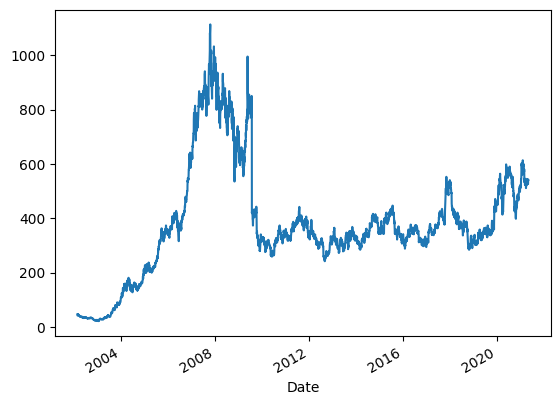

In [ ]:
df['VWAP'].plot()

In [ ]:
output_var = pd.DataFrame(df['VWAP'])

features = ['Open', 'High', 'Low', 'Volume']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

import joblib
joblib.dump(scaler, 'scaler_BHARTIARTL.pkl')

['scaler_BHARTIARTL.pkl']

In [ ]:
feature_transform.shape

(4774, 4)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=25)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(4591, 4)
(183, 4)


In [ ]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(4591, 1, 4)
(183, 1, 4)


In [ ]:
import tensorflow as tf

lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))


lstm.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                       │ (None, 1, 32)               │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_89 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,633 (115.75 KB)

 Trainable params: 29,633 (115.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, validation_data=(X_test, y_test))

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 151074.6875 - mse: 151074.6875 - val_loss: 260490.6875 - val_mse: 260490.6875
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 139950.6719 - mse: 139950.6719 - val_loss: 188169.6875 - val_mse: 188169.6875
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 85794.7344 - mse: 85794.7344 - val_loss: 55555.7930 - val_mse: 55555.7930
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22769.6738 - mse: 22769.6738 - val_loss: 3461.3203 - val_mse: 3461.3203
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8788.6387 - mse: 8788.6387 - val_loss: 1558.0325 - val_mse: 1558.0325
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7902.7734 - mse: 7902.7734 - val_loss: 1432.1539 - val_mse: 1432.1539
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6841.3662 - mse: 6841.3662 - val_loss: 1311.6622 - val_mse: 1311.6622
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

In [ ]:
lstm.save('/content/model_BHARTIARTL.h5')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mse,val_loss,val_mse
0,183291.796875,183291.796875,260490.687500,260490.687500
1,162414.531250,162414.531250,188169.687500,188169.687500
2,87997.468750,87997.468750,55555.792969,55555.792969
3,19161.500000,19161.500000,3461.320312,3461.320312
4,4966.102051,4966.102051,1558.032471,1558.032471
...,...,...,...,...
95,62.643356,62.643356,43.173275,43.173275
96,61.857780,61.857780,43.028175,43.028175
97,61.083961,61.083961,42.892242,42.892242
98,60.324764,60.324764,42.765621,42.765621


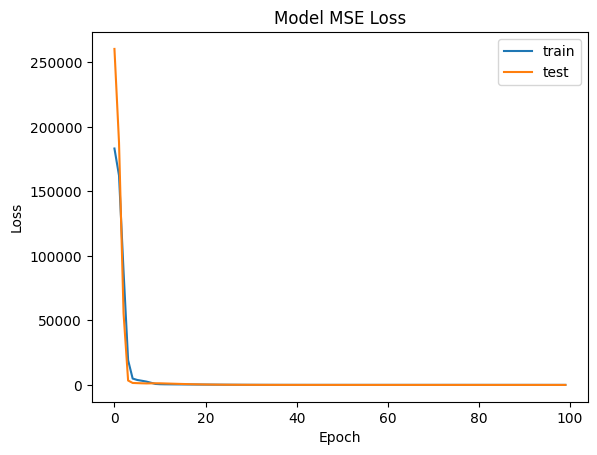

In [ ]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

In [ ]:
y_pred= lstm.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 42.648088935909115


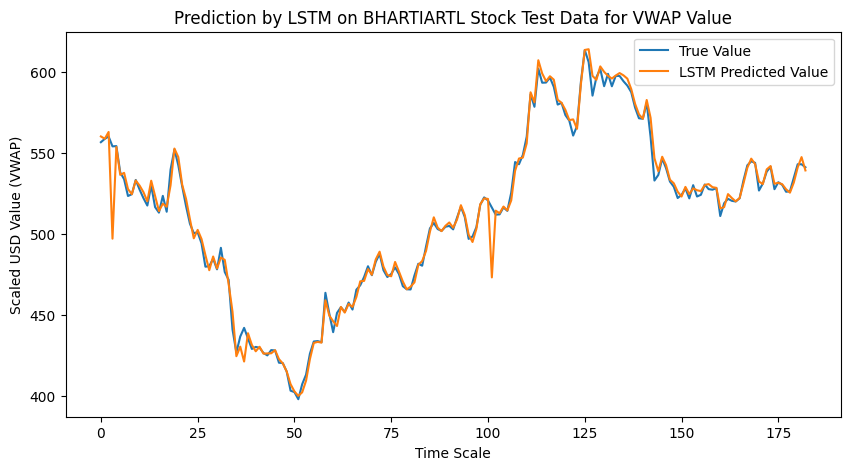

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Prediction by LSTM on BHARTIARTL Stock Test Data for VWAP Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD Value (VWAP)')
plt.legend()
plt.show()

## Predicting RELIANCE VWAP (Volume Weighted Average Price)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/RELIANCE.csv')

In [ ]:
len(df)

5306

In [ ]:
df['Trades'].isnull().sum() / len(df)

0.5371277798718432

- 53.71% of the data in trades column is null, so we drop it

In [ ]:
df = df.drop(columns=['Trades'])

In [ ]:
df.isnull().sum()

,0
Date,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0


<Axes: xlabel='Date'>

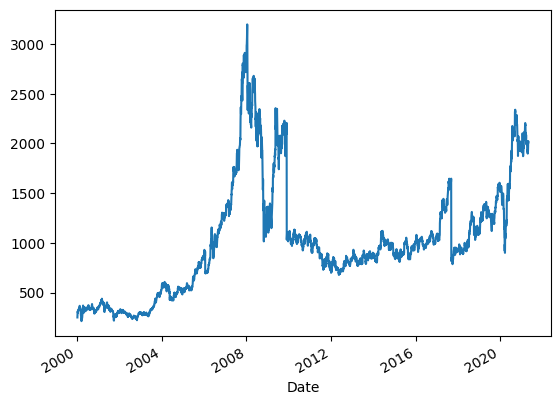

In [ ]:
import matplotlib.pyplot as plt
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df['VWAP'].plot()

- We select 'High', 'Low', 'Volume', 'Open' as our columns of interest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

np.random.seed(42)

columns_to_modify = ['High', 'Low', 'Volume', 'Open']

for column in columns_to_modify:
    nan_indices = np.random.choice(df.index, size=10, replace=False)
    df.loc[nan_indices, column] = np.nan

print("Summary of missing values after introducing NaNs:")
print(df.isnull().sum())

Summary of missing values after introducing NaNs:
Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                   10
High                   10
Low                    10
Last                    0
Close                   0
VWAP                    0
Volume                 10
Turnover                0
Deliverable Volume    514
%Deliverble           514
dtype: int64


In [ ]:
numerical_columns = ['High', 'Low', 'Volume', 'Open']

for column in numerical_columns:
    df[column] = df[column].fillna(df[column].mean())

print("Summary of missing values after imputation:")
print(df.isnull().sum())

Summary of missing values after imputation:
Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Deliverable Volume    514
%Deliverble           514
dtype: int64


<Axes: xlabel='Date'>

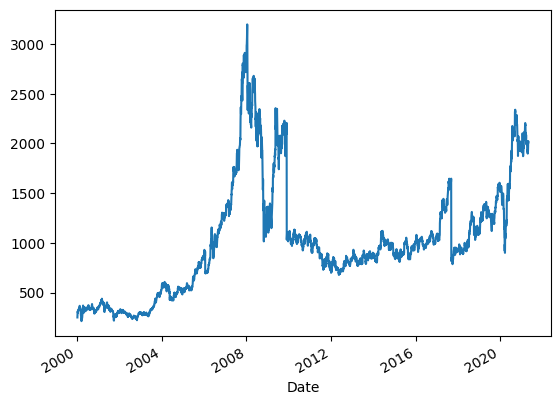

In [ ]:
df['VWAP'].plot()

In [ ]:
output_var = pd.DataFrame(df['VWAP'])

features = ['Open', 'High', 'Low', 'Volume']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

import joblib
joblib.dump(scaler, 'scaler_RELIANCE.pkl')

['scaler_RELIANCE.pkl']

In [ ]:
feature_transform.shape

(5306, 4)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=25)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5102, 4)
(204, 4)


In [ ]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(5102, 1, 4)
(204, 1, 4)


In [ ]:
import tensorflow as tf

lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))


lstm.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                       │ (None, 1, 32)               │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_91 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,633 (115.75 KB)

 Trainable params: 29,633 (115.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, validation_data=(X_test, y_test))

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 821625.5000 - mse: 821625.5000 - val_loss: 4172352.2500 - val_mse: 4172352.2500
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 791510.5000 - mse: 791510.5000 - val_loss: 3657428.7500 - val_mse: 3657428.7500
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 639413.4375 - mse: 639413.4375 - val_loss: 2393451.0000 - val_mse: 2393451.0000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 353551.0625 - mse: 353551.0625 - val_loss: 886638.7500 - val_mse: 886638.7500
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117415.1406 - mse: 117415.1406 - val_loss: 178895.7969 - val_mse: 178895.7969
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61697.1914 - mse: 61697.1914 - val_loss: 49154.6211 - val_mse: 49154.6211
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60469.9102 - mse: 60469.9102 - val_loss: 29454.5000 - val_mse: 29454.5000
Epoch 8/100
160/160 ━━━━━━━━━

In [ ]:
lstm.save('/content/model_RELIANCE.h5')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mse,val_loss,val_mse
0,1.233060e+06,1.233060e+06,4.172352e+06,4.172352e+06
1,1.163129e+06,1.163129e+06,3.657429e+06,3.657429e+06
2,8.970520e+05,8.970520e+05,2.393451e+06,2.393451e+06
3,4.594455e+05,4.594455e+05,8.866388e+05,8.866388e+05
4,1.371472e+05,1.371472e+05,1.788958e+05,1.788958e+05
...,...,...,...,...
95,2.765446e+02,2.765446e+02,7.964464e+02,7.964464e+02
96,2.756026e+02,2.756026e+02,7.961812e+02,7.961812e+02
97,2.746690e+02,2.746690e+02,7.959098e+02,7.959098e+02
98,2.737454e+02,2.737454e+02,7.956400e+02,7.956400e+02


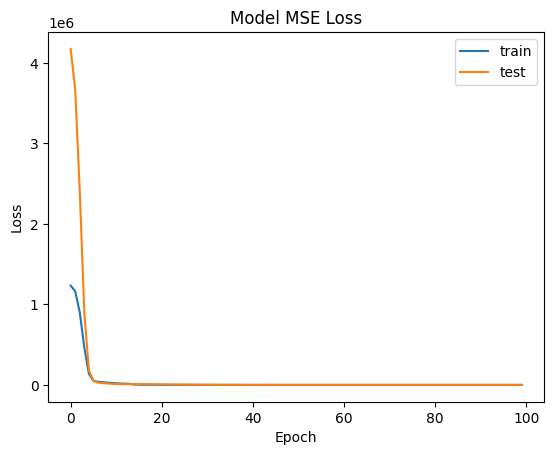

In [ ]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

In [ ]:
y_pred= lstm.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 795.375417920728


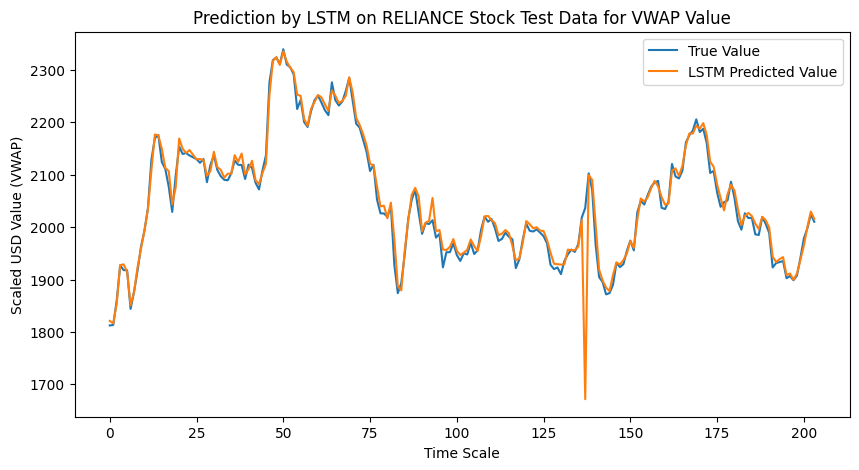

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Prediction by LSTM on RELIANCE Stock Test Data for VWAP Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD Value (VWAP)')
plt.legend()
plt.show()

## Predicting HCLTECH VWAP (Volume Weighted Average Price)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/.cache/kagglehub/datasets/rohanrao/nifty50-stock-market-data/versions/15/HCLTECH.csv')

In [ ]:
len(df)

5300

In [ ]:
df['Trades'].isnull().sum() / len(df)

0.5366037735849056

- 40.66% of the data in trades column is null, so we drop it

In [ ]:
df = df.drop(columns=['Trades'])

In [ ]:
df.isnull().sum()

,0
Date,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0


<Axes: xlabel='Date'>

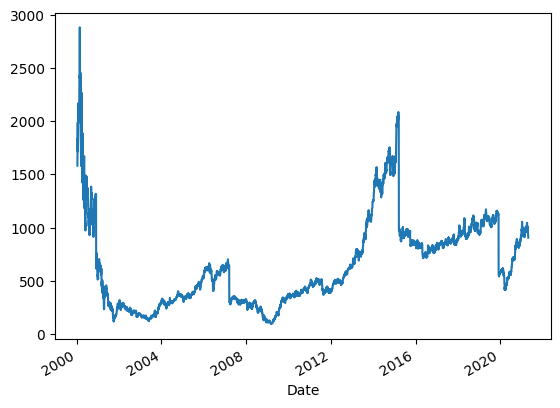

In [ ]:
import matplotlib.pyplot as plt
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df['VWAP'].plot()

- We select 'High', 'Low', 'Volume', 'Open' as our columns of interest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

np.random.seed(42)

columns_to_modify = ['High', 'Low', 'Volume', 'Open']

for column in columns_to_modify:
    nan_indices = np.random.choice(df.index, size=10, replace=False)
    df.loc[nan_indices, column] = np.nan

print("Summary of missing values after introducing NaNs:")
print(df.isnull().sum())

Summary of missing values after introducing NaNs:
Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                   10
High                   10
Low                    10
Last                    0
Close                   0
VWAP                    0
Volume                 10
Turnover                0
Deliverable Volume    503
%Deliverble           503
dtype: int64


In [ ]:
numerical_columns = ['High', 'Low', 'Volume', 'Open']

for column in numerical_columns:
    df[column] = df[column].fillna(df[column].mean())

print("Summary of missing values after imputation:")
print(df.isnull().sum())

Summary of missing values after imputation:
Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Deliverable Volume    503
%Deliverble           503
dtype: int64


<Axes: xlabel='Date'>

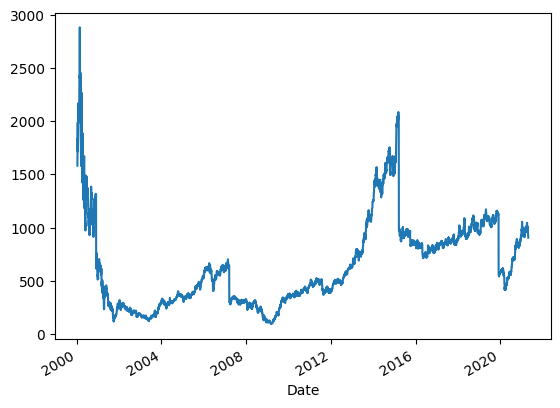

In [ ]:
df['VWAP'].plot()

In [ ]:
output_var = pd.DataFrame(df['VWAP'])

features = ['Open', 'High', 'Low', 'Volume']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

import joblib
joblib.dump(scaler, 'scaler_HCLTECH.pkl')

['scaler_HCLTECH.pkl']

In [ ]:
feature_transform.shape

(5300, 4)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=25)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5097, 4)
(203, 4)


In [ ]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(5097, 1, 4)
(203, 1, 4)


In [ ]:
import tensorflow as tf

lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))


lstm.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_92 (LSTM)                       │ (None, 1, 32)               │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_93 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,633 (115.75 KB)

 Trainable params: 29,633 (115.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, validation_data=(X_test, y_test))

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 644154.2500 - mse: 644154.2500 - val_loss: 738092.3750 - val_mse: 738092.3750
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 625451.8750 - mse: 625451.8750 - val_loss: 581975.1875 - val_mse: 581975.1875
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 499263.6875 - mse: 499263.6875 - val_loss: 262648.7812 - val_mse: 262648.7812
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 270244.6562 - mse: 270244.6562 - val_loss: 36033.6367 - val_mse: 36033.6367
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 104182.2344 - mse: 104182.2344 - val_loss: 18201.0586 - val_mse: 18201.0586
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59845.6719 - mse: 59845.6719 - val_loss: 26695.6133 - val_mse: 26695.6133
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 48323.2695 - mse: 48323.2695 - val_loss: 26504.3867 - val_mse: 26504.3867
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━

In [ ]:
lstm.save('/content/model_HCLTECH.h5')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mse,val_loss,val_mse
0,573602.812500,573602.812500,738092.375000,738092.375000
1,530562.125000,530562.125000,581975.187500,581975.187500
2,370179.750000,370179.750000,262648.781250,262648.781250
3,158535.140625,158535.140625,36033.636719,36033.636719
4,54332.000000,54332.000000,18201.058594,18201.058594
...,...,...,...,...
95,215.348633,215.348633,46.754871,46.754871
96,214.701889,214.701889,45.739079,45.739079
97,214.090820,214.090820,44.810146,44.810146
98,213.522415,213.522415,43.937614,43.937614


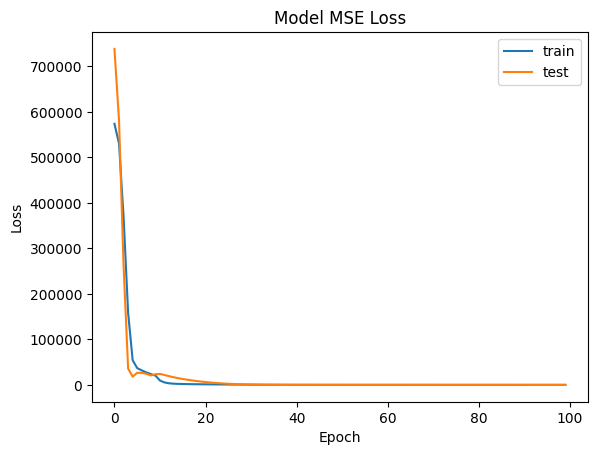

In [ ]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

In [ ]:
y_pred= lstm.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 43.138063321773345


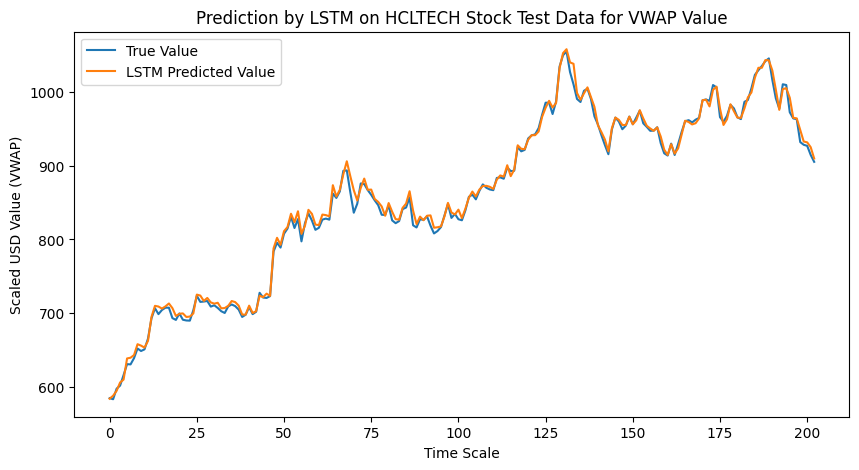

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Prediction by LSTM on HCLTECH Stock Test Data for VWAP Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD Value (VWAP)')
plt.legend()
plt.show()

### Plotting model architecture diagram

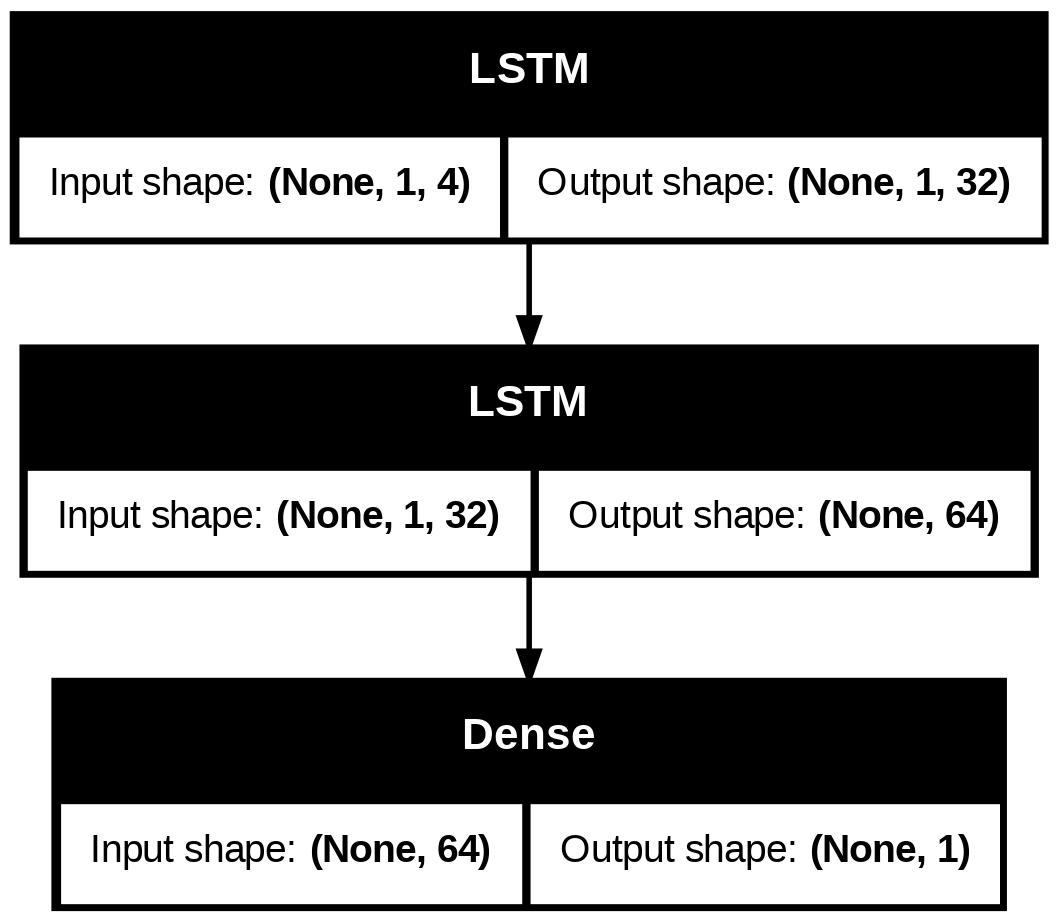

In [ ]:
tf.keras.utils.plot_model(lstm, show_shapes=True)